In [236]:
#! usr/bin/env python3

import cv2
import pytesseract
from matplotlib import pyplot as plt
import numpy as np

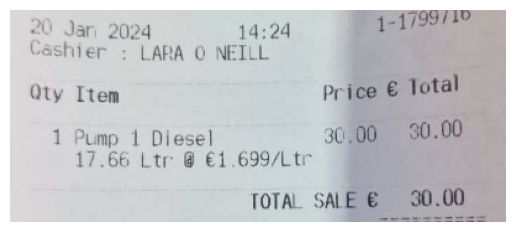

In [237]:
image_path = 'images/reciepts/test6.png'
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [238]:
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh

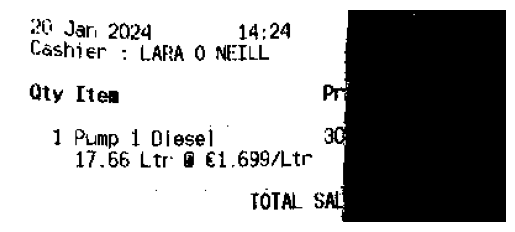

In [239]:
plt.imshow(preprocess(image), cmap='gray')
plt.axis('off')
plt.show()

In [240]:

custom_config = r'--oem 3 --psm 6 outputbase'

text = pytesseract.image_to_string(image, config=custom_config)
filtered_text = '\n'.join(
    line for line in text.split('\n') if line.strip() != '')

print(filtered_text)

20 Jan 2024 14:24
Cashier : LARA O NEILL
Qty Ttem
1 Pump 1 Diesel 30,
17.66 Ltr @ €1.699/Ltr
TOTAL SAL


In [241]:
import re
from fuzzywuzzy import process

#! TODO: Apply preprocessing if text not found

def extract_receipt_info_single(receipt_text):

    text_lower = receipt_text.lower()

    info = {
        'fuel_type': None,
        'volume': None,
        'price_per_litre': None,
        'total': None
    }

    # https://stackoverflow.com/questions/1547574/regex-for-prices
    volume_pattern = r"(?i)(?:volume|;|:|diesel|unleaded|pump\s*([a-z]|[0-9])|\))\s*(\d+(?:[.,]\d{2}))\s*°?\s*(ltr|l|net)?"

    price_per_litre_pattern = r"(?:price|€)\s*([1-9]?\s*[.,]\d{3})\s*(eur/l|/l|/)?\s*"

    fuel_type_choices = ["unleaded", "diesel"]

    # Search for fuel type with fuzzy match
    fuel_type_match = process.extractOne(text_lower, fuel_type_choices, score_cutoff=50)
    if fuel_type_match:
        info['fuel_type'] = fuel_type_match[0]

    # Search for volume
    volume_match = re.search(volume_pattern, text_lower)
    if volume_match:
        info['volume'] = next((m for m in volume_match.groups() if m), None)
        if info['volume'] is not None:
            info['volume'] = info['volume'].replace(' ','').replace(',', '.')

    # Search for price per litre
    price_per_litre_match = re.search(price_per_litre_pattern, text_lower)
    if price_per_litre_match:
        info['price_per_litre'] = next((m for m in price_per_litre_match.groups() if m), None)
        if info['price_per_litre'] is not None:
            info['price_per_litre'] = info['price_per_litre'].replace(' ','').replace(',', '.')

    if info['volume'] is not None and info['price_per_litre'] is not None:
        total = float(info['volume']) * float(info['price_per_litre'])
        total = round(total, 2)
        info['total'] = total
    else:
        info['total'] = None 

    return info

extracted_info_single = extract_receipt_info_single(filtered_text)
print(extracted_info_single)


{'fuel_type': 'diesel', 'volume': None, 'price_per_litre': '1.699', 'total': None}
